In [1]:
import numpy as np
from keras.src.saving.saving_api import load_model
from keras.src.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.src.utils.numerical_utils import to_categorical
from PIL import Image
import tensorflow as tf
import os

import matplotlib.pyplot as plt

In [2]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',      
            2:'Speed limit (50km/h)',       
            3:'Speed limit (60km/h)',      
            4:'Speed limit (70km/h)',    
            5:'Speed limit (80km/h)',      
            6:'End of speed limit (80km/h)',     
            7:'Speed limit (100km/h)',    
            8:'Speed limit (120km/h)',     
           9:'No passing',   
           10:'No passing veh over 3.5 tons',     
           11:'Right-of-way at intersection',     
           12:'Priority road',    
           13:'Yield',     
           14:'Stop',       
           15:'No vehicles',       
           16:'Veh > 3.5 tons prohibited',       
           17:'No entry',       
           18:'General caution',     
           19:'Dangerous curve left',      
           20:'Dangerous curve right',   
           21:'Double curve',      
           22:'Bumpy road',     
           23:'Slippery road',       
           24:'Road narrows on the right',  
           25:'Road work',    
           26:'Traffic signals',      
           27:'Pedestrians',     
           28:'Children crossing',     
           29:'Bicycles crossing',       
           30:'Beware of ice/snow',
           31:'Wild animals crossing',      
           32:'End speed + passing limits',      
           33:'Turn right ahead',     
           34:'Turn left ahead',       
           35:'Ahead only',      
           36:'Go straight or right',      
           37:'Go straight or left',      
           38:'Keep right',     
           39:'Keep left',      
           40:'Roundabout mandatory',     
           41:'End of no passing',      
           42:'End no passing veh > 3.5 tons' }

In [3]:
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((30, 30))
    image = image.convert('RGB')
    image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)
    return image

In [4]:
def load_data_from_csv(csv_file):
    data = []
    labels = []
    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        for line in lines:
            parts = line.strip().split(',')
            image_path = parts[-1]
            try:
                image = load_image(image_path)  # Sử dụng hàm load_image() thay vì mở và xử lý ảnh trực tiếp
                data.append(image)
                labels.append(int(parts[-2]))  # ClassId là phần thứ 7 từ cuối dòng
            except Exception as e:
                print(f"Error loading image: {e}")
    return np.array(data), np.array(labels)

In [5]:
# Load mô hình đã được lưu
model = load_model("my_model.h5")
adv_model = load_model("adversarial_model.h5")

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Load dữ liệu thử nghiệm
X_test, y_test = load_data_from_csv("test.csv")

In [7]:
X_train, y_train = load_data_from_csv("Train.csv")

In [8]:
def fgsm_attack(model, image, label, epsilon):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)  # Remove extra dimension
    label_tensor = tf.convert_to_tensor([label], dtype=tf.int64)
    
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label_tensor, prediction)
    
    gradient = tape.gradient(loss, image_tensor)
    signed_grad = tf.sign(gradient)
    perturbed_image = image_tensor + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 255)
    
    return perturbed_image.numpy()[0]

In [9]:
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array

def load_perturbed_images(save_dir='fgsm_train', num_images=39209, img_shape=(30, 30, 3)):
    X_per = np.zeros((num_images, *img_shape))
    y_per = np.zeros((num_images,))  # Giả sử y_per chỉ chứa nhãn gốc từ y_train

    for i in range(num_images):
        # Tạo đường dẫn để tải ảnh
        file_path = os.path.join(save_dir, 'perturbed_image_{}.png'.format(i))
        
        # Tải ảnh và chuyển đổi thành mảng numpy
        image = load_img(file_path, target_size=img_shape[:2])
        image_array = img_to_array(image)
        
        # Lưu ảnh vào X_per
        X_per[i] = image_array
        
        # Lưu nhãn tương ứng vào y_per (giả sử nhãn gốc từ y_train)
        y_per[i] = y_train[i]
    
    return X_per, y_per

# Giả sử y_train đã được định nghĩa và nạp từ trước
X_per, y_per = load_perturbed_images()

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

# Giả sử model đã được định nghĩa và nạp từ trước
# Dự đoán nhãn cho tập ảnh X_per
y_pred = model.predict(X_per)

# Tính nhãn dự đoán từ các xác suất
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính độ chính xác trên tập dữ liệu tấn công
accuracy = accuracy_score(y_per, y_pred_classes)
print(f"Accuracy on pertubate data: {accuracy}")

# Tính độ tự tin cao nhất cho mỗi ảnh
confidence_scores = np.max(y_pred, axis=1)

# Tính trung bình độ tự tin
average_confidence = np.mean(confidence_scores)
print(f"Average confidence on adversarial images: {average_confidence:.4f}")

1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Accuracy on pertubate data: 0.6574510954117677
Average confidence on adversarial images: 0.9164


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# Giả sử model đã được định nghĩa và nạp từ trước
# Dự đoán nhãn cho tập ảnh X_per
y_pred = adv_model.predict(X_per)

# Tính nhãn dự đoán từ các xác suất
y_pred_classes = np.argmax(y_pred, axis=1)

# Tính độ chính xác trên tập dữ liệu tấn công
accuracy = accuracy_score(y_per, y_pred_classes)
print(f"Accuracy on test data: {accuracy}")

# Tính độ tự tin cao nhất cho mỗi ảnh
confidence_scores = np.max(y_pred, axis=1)

# Tính trung bình độ tự tin
average_confidence = np.mean(confidence_scores)
print(f"Average confidence on adversarial images: {average_confidence:.4f}")

1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Accuracy on test data: 0.8918615623963886
Average confidence on adversarial images: 0.8811


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


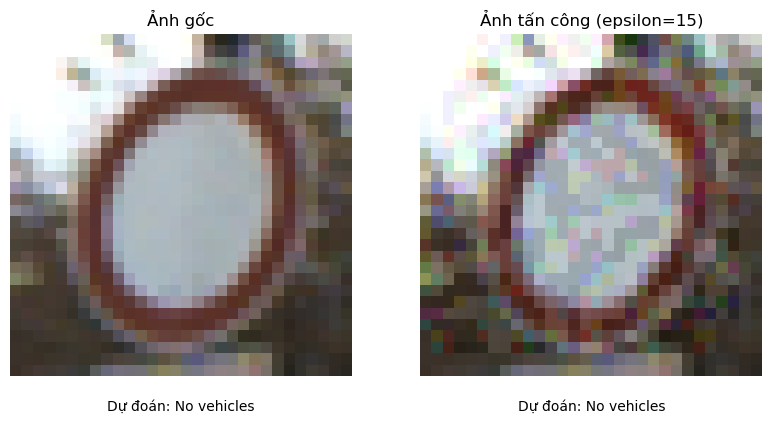

In [13]:
# Mức độ nhiễu
rand_index = 5320
epsilon = 15
image = X_test[rand_index]
label = y_test[rand_index]
perturbed_image = fgsm_attack(model, image, label, epsilon)
# Dự đoán nhãn của ảnh tấn công
perturbed_pr = adv_model.predict(perturbed_image.reshape(1, 30, 30, 3))
perturbed_label = np.argmax(perturbed_pr)

# Hiển thị ảnh gốc và ảnh tấn công
plt.figure(figsize=(15, 5))

# Ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().astype(int))  # Squeeze để loại bỏ chiều thêm
plt.title('Ảnh gốc')
plt.text(0.5, -0.1, 'Dự đoán: {}'.format(classes[label]), ha='center', transform=plt.gca().transAxes)  # Thêm dự đoán của ảnh gốc
plt.axis('off')

# Ảnh tấn công
plt.subplot(1, 3, 2)
plt.imshow(perturbed_image.astype(int))
plt.title('Ảnh tấn công (epsilon={})'.format(epsilon))
plt.text(0.5, -0.1, 'Dự đoán: {}'.format(classes[perturbed_label]), ha='center', transform=plt.gca().transAxes)  # Thêm dự đoán của ảnh tấn công
plt.axis('off')

plt.show()

In [14]:
# Dự đoán nhãn của ảnh gốc và ảnh tấn công
pr = adv_model.predict(perturbed_image.reshape(1, 30, 30, 3))
confidence = np.max(pr)  # Độ tự tin của mô hình là xác suất cao nhất trong vector dự đoán
predicted_label = np.argmax(pr)
predicted_label_name = classes[predicted_label]

# Hiển thị độ tự tin và nhãn dự đoán
print("Độ tự tin của mô hình khi dự đoán ảnh nhiễu là:", confidence)
print("Nhãn dự đoán của ảnh nhiễu là:", predicted_label_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Độ tự tin của mô hình khi dự đoán ảnh nhiễu là: 1.0
Nhãn dự đoán của ảnh nhiễu là: No vehicles


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


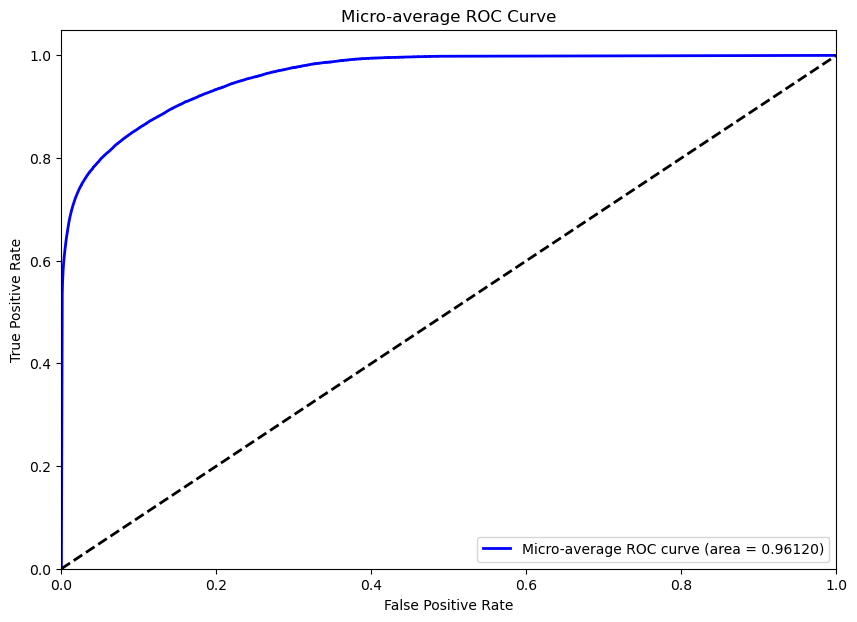

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Binarize the output
n_classes = len(np.unique(y_per))
y_test_bin = label_binarize(y_per, classes=np.arange(n_classes))
y_score = model.predict(X_per)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.5f})'
             ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


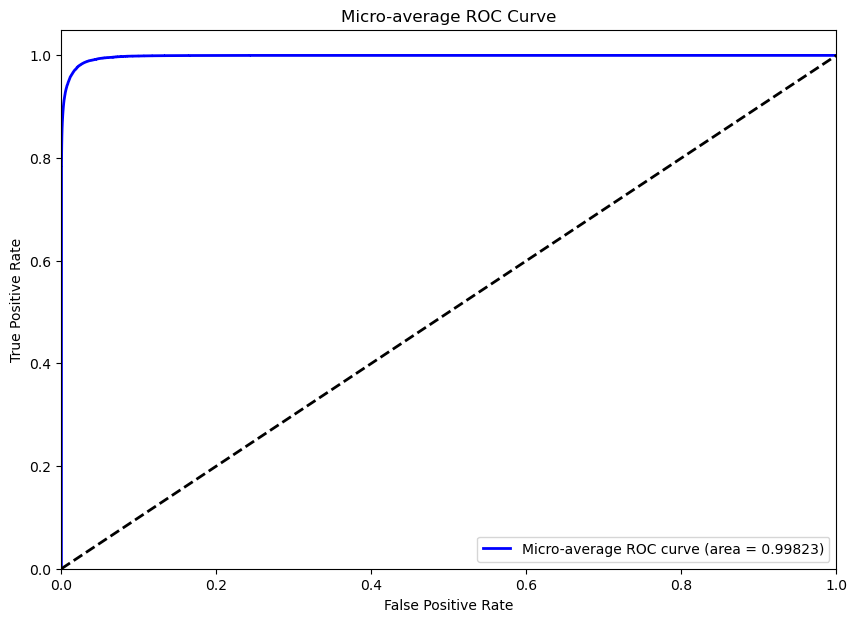

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Binarize the output
n_classes = len(np.unique(y_per))
y_test_bin = label_binarize(y_per, classes=np.arange(n_classes))
y_score = adv_model.predict(X_per)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot micro-average ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2, label='Micro-average ROC curve (area = {0:0.5f})'
             ''.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()
